# thermoNET model improvement via Neural ODEs

In this notebook, we show how the differentiability of the thermoNET can be used to update the weights and biases of the network for some given downstream task.

In this case, we focus on trajectory estimation: our objective is to improve the thermoNET model to better match simulated or observed satellite trajectories. The idea is that after having trained a thermoNET on a given model (e.g. see `nrlmsise00_train.ipynb` or `jb08_train.ipynb`), the parameters of the network can be still adjusted to match external simulated or observed data, for a specific downstream task of interest: this can be done leveraging the Neural ODE framework.


In [1]:
import sys
sys.path.append('../')
import numpy as np
import thermonets as tn
import datetime
import heyoka as hk
import pickle
import time
from nrlmsise00 import msise_flat
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

The EOP file 'finals2000A.all' in /Users/ga00693/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/ga00693/src/iers/ is already the latest.


## 1 - Equations of motion

In the notebook `orbit_propagation_with_thermoNET.ipynb`, we have introduced the simplified equations of motion for a satellite in LEO with drag. As we have shown, we replace the thermospheric density model in the drag term (i.e., NRLMSISE-00, or JB-08, ..) with a neural network. We will now construct the equations of motion and the integrator, without discussing again all the assumptions and theory. If interested, the reader can checkout the abovementioned notebook.

First, some useful constants:

In [2]:
#First we need to set some variables useful for integration:
mu = 3.986004407799724e14                  #Earth gravitational parameter SI
r_earth = 6378.1363*1e3                    #Earth radius SI
initial_h=280.*1e3                         #Satellite's initial altitude SI
mass=200                                   #mass of the satellite SI
area=2                                     #drag cross-sectional area of the satellite in SI
cd=2.2                                     #drag coefficient [-]
bc = mass/(cd*area)                        #ballistic coefficient in SI
omega_e = 7.2921150e-5                     #Earth rotation rate SI
date0 = datetime.datetime(2015,3,4,9,0,0) #initial absolute time for the propagation
date0_mjd = tn.mjd(date0)
#we extract the spaceweather indices for the date of the integration
f107,f107a,s107,s107a,m107,m107a,y107,y107a,dDstdT = tn.get_jb08_spaceweather_indices(date0)

#we assume a circular orbit at first
initial_state=[r_earth+initial_h,0.,0., 0., np.sqrt(mu/(r_earth+initial_h)),0.]
t_span=(0.,60.*60.*10.) #10 hours propagation


The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/ga00693/src/sw-data/ are already the latest.


Now, let us construct the equations of motion with the thermoNET neural model, and let's use the Taylor propagator `heyoka` to integrate them.

First, we need to load the models weights and biases:

In [3]:
#NN in heyoka - creation
with open('../models/nn_parameters_jb08_model_10_32_32_1.43.pk','rb') as f:
     weights,biases=pickle.load(f)
#we need to flatten them for feeding them to heyoka: 
weights_flat=[]
biases_flat=[] 
for i in range(len(weights)):
    weights_flat+=list(weights[i].T.flatten())
    biases_flat+=list(biases[i].flatten())
weights_flat=np.array(weights_flat)
biases_flat=np.array(biases_flat)
flattened_nw=np.concatenate((weights_flat,biases_flat))

then we prepare all the inputs for the network:

In [4]:
#we first instantiate the state variables as heyoka variables:
x,y,z,vx,vy,vz=hk.make_vars("x","y","z","vx","vy","vz")
#we construct the Earth rotation matrix, assuming that at t=0 the vernal equinox is aligned with the x-axis of the ECEF frame (prime meridian)
R=[[hk.cos(omega_e*hk.time),hk.sin(omega_e*hk.time)],[-hk.sin(omega_e*hk.time),hk.cos(omega_e*hk.time)]]
#we transform x,y into the ECEF frame:
xy_ecef=np.matmul(R,[x,y])
#transformation from Cartesian to Geodetic:
altitude,lat,lon=tn.cart2geo(xy_ecef[0],xy_ecef[1],z,symbolic=True)
#first latitude and longitude
sin_lon=hk.sin(lon)
cos_lon=hk.cos(lon)
lat_n=tn.normalize_min_max(lat,-np.pi/2,np.pi/2)
# This is the date we start our integration at
offset=date0.second+date0.minute*60.+date0.hour*3600.
#seconds in the day
sec_in_day_n=(hk.time+offset)/86400.*2*np.pi
sin_sec_in_day=hk.sin(sec_in_day_n)
cos_sec_in_day=hk.cos(sec_in_day_n)
#day of the year
doy=date0.timetuple().tm_yday+hk.time/86400.
sin_doy = hk.sin(2*np.pi*doy/365.25)
cos_doy = hk.cos(2*np.pi*doy/365.25)

f107_n=tn.normalize_min_max(f107, 60., 266.)
f107a_n=tn.normalize_min_max(f107a, 60., 170.)
s107_n=tn.normalize_min_max(s107, 50., 190.)
s107a_n=tn.normalize_min_max(s107a, 50., 170.)
m107_n=tn.normalize_min_max(m107, 50., 190.)
m107a_n=tn.normalize_min_max(m107a, 50., 160.)
y107_n=tn.normalize_min_max(y107, 50., 180.)
y107a_n=tn.normalize_min_max(y107a, 50., 170.)
dDstdT_n=tn.normalize_min_max(dDstdT, 0., 390.)


we load the global fit

In [5]:
with open('../global_fits/global_fit_jb08_180.0-1000.0-4.txt','rb') as f:
    best_global_fit=pickle.load(f)


then we construct the thermoNET:

In [6]:
#we now construct the neural network in heyoka:
delta_params=hk.model.ffnn(inputs=[sin_lon,cos_lon,lat_n,sin_sec_in_day, cos_sec_in_day, sin_doy, cos_doy, hk.expression(f107_n), hk.expression(f107a_n), hk.expression(s107_n), hk.expression(s107a_n), hk.expression(m107_n), hk.expression(m107a_n), hk.expression(y107_n), hk.expression(y107a_n), hk.expression(dDstdT_n)],
                           nn_hidden=[32,32], 
                           n_out=12, 
                           activations=[hk.tanh,hk.tanh,hk.tanh]#, nn_wb=flattened_nw
                           )

#and use this to construct the density:
params=[best_global_fit[i]*(1+delta_params[i]) for i in range(12)]
density_nn = tn.rho_approximation(altitude/1e3,params,backend='heyoka')
print(density_nn)

((exp(((0.0036156275901554277 + (0.0036156275901554277 * tanh((p1988 + (p1664 * tanh((p1952 + (p512 * tanh((p1920 + (0.24545454545454537 * p8) + (0.27000000000000002 * p9) + (0.31142857142857161 * p11) + (0.40769230769230780 * p13) + (0.44833333333333347 * p10) + (0.57499999999999996 * p14) + (0.59636363636363665 * p12) + (0.63661977236758138 * p2 * atan((z / ((1.0000000000000000 - ((42697.672707539066 * cos(atan((z / ((1.0000000000000000 - ((42697.672707539066 * cos(atan((z / ((1.0000000000000000 - ((42697.672707539066 * cos(atan((z / ((1.0000000000000000 - ((42697.672707539066 * cos(atan(((1.0067394967423335 * z) / (((y * cos((7.2921149999999999e-05 * t))) - (x * sin((7.2921149999999999e-05 * t))))**2.0000000000000000 + ((x * cos((7.2921149999999999e-05 * t))) + (y * sin((7.2921149999999999e-05 * t))))**2.0000000000000000)**0.50000000000000000)))) / ((1.0000000000000000 - (0.0066943799901976186 * sin(atan(((1.0067394967423335 * z) / (((y * cos((7.2921149999999999e-05 * t))) - (x * si

finally let's construct the equations of motion:

In [7]:
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

vrel_x=vx+omega_e*y
vrel_y=vy-omega_e*x
adragx=-1/2*density_nn*vx*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
adragy=-1/2*density_nn*vy*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
adragz=-1/2*density_nn*vz*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
dyn_drag=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]

## 2 - Variational Equations

As shown above, the equations of motion have the following form:

\begin{equation}
\dot{\pmb{x}}=\pmb{f}(\pmb{x}, t, \pmb{\theta} )\text{,}
\end{equation}

where $\pmb{\theta}$ is the vector of weights and biases (i.e., parameters) of the neural network $\mathcal{N}$. Due to the presence of a neural network in the right-hand side of the equations of motion, these ODEs are also known as [Neural ODEs](https://arxiv.org/abs/1806.07366). Even though the parameters have been already trained for a specific task (i.e., match a certain density model), we are now introducing this model in a dynamical system, and we might want to minimize a certain objective function (i.e., loss):
\begin{equation}
\mathcal{L}(\pmb{x}(\pmb{x}_0, \pmb{\theta},t))\text{.}
\end{equation}

For instance, we might want to minimize the residual error between a trajectory predicted with thermoNET and one found via a another orbit propagation model, or an observed one. 

In this way, we would change the network parameters to have a better agreement with ground truth data or precise orbit propagation.

How? Leveraging the differentiability of the neural networks, we can setup a stochastic gradient descent training pipeline. Our minimization problem consists in correcting the neural network parameters (i.e., $\pmb{\theta}$) so that a certain loss is minimized:

\begin{equation}
\mathcal{P}:
\begin{cases}
&\textrm{given} \ \pmb{x}_0, t_0\\
&\textrm{find} \ \pmb{\theta}\\
&\textrm{to} \ \textrm{minimize} \ \mathcal{L}_\theta(\pmb{x}) 
\end{cases}
\end{equation}

Once the gradient of the loss w.r.t. $\pmb{\theta}$ is found, the parameters can be iteratively updated, starting from the initial network parameters. For instance following the direction opposite to the loss gradient:

\begin{equation}
\pmb{\theta}_{i+1}=\pmb{\theta}_i-\alpha\dfrac{\partial \mathcal{L}}{\partial \pmb{\theta}}=\pmb{\theta}_i-\alpha\dfrac{\partial \mathcal{L}}{\partial \pmb{x}}\frac{\partial \pmb{x}}{\partial \pmb{\theta}} \text{,}
\end{equation}
where $\alpha$ is the learning rate.

To make the above computation, we need to first compute the partial derivative of the loss w.r.t. the state, and then, to compute the partials of the state w.r.t. the network parameters, we need to solve the following variational equations:

\begin{equation}
\dfrac{\partial}{\partial \pmb{\theta}}\dfrac{d\pmb{x}}{dt} = \dfrac{\partial\pmb{f}}{\partial \pmb{\theta}}
\end{equation}

By further developing both the left and right-hand side, we get:

\begin{equation}
\dfrac{d}{dt}\dfrac{\partial \pmb{x}}{\partial \pmb{\theta}} = \dfrac{\partial \pmb{f}}{\partial \pmb{x}}\dfrac{\partial \pmb{x}}{\partial \pmb{\theta}}+\dfrac{\partial \pmb{f}}{\partial \pmb{\theta}}
\end{equation}

Assuming that $\pmb{x}\in \mathbb{R}^n$ and $\pmb{\theta}\in \mathbb{R}^m$, the above is a set of (n,m) variational equations that regulate all the evolution of the $\dfrac{\partial \pmb{x}}{\partial\pmb{\theta}}$ in time. 

Once these $m+n$ equations are solved, these terms are known at all integration times, thereby allowing to use them to update the network parameters.


Let us know proceed and define the variational equations in `heyoka`:

In [8]:
dynamics = [d[1] for d in dyn_drag]
dFdtheta = hk.diff_tensors(dynamics, diff_args=hk.diff_args.params,diff_order=1)
dFdtheta = dFdtheta.jacobian
print("Shape of dFdtheta:", dFdtheta.shape)

dFdx = hk.diff_tensors(dynamics, [x,y,z,vx,vy,vz])
dFdx= dFdx.jacobian
print("Shape of dFdx:", dFdx.shape)

Shape of dFdtheta: (6, 1996)
Shape of dFdx: (6, 6)


In [9]:
symbols_phi = []
for i in range(6):
    for j in range(6):
        # Here we define the symbol for the variations
        symbols_phi.append("phi_"+str(i)+str(j))  
phi = np.array(hk.make_vars(*symbols_phi)).reshape((6, 6))

# We define the symbols for varphi
symbols_varphi = []
for i in range(dFdtheta.shape[0]):
    for j in range(dFdtheta.shape[1]):
        # Here we define the symbol for the variations
        symbols_varphi.append("varphi_"+str(i)+str(j))  
varphi = np.array(hk.make_vars(*symbols_varphi)).reshape((dFdtheta.shape[0], dFdtheta.shape[1]))

In [10]:
# The (variational) equations of motion in matrix form
dphidt = dFdx@phi
dvarphidt =  dFdx.T@varphi + dFdtheta

In [11]:
dyn = []
# The \dot x = f
for lhs, rhs in dyn_drag:
    dyn.append((lhs, rhs))
# The variational equations for x0
for lhs, rhs in zip(phi.flatten(),dphidt.flatten()):
    dyn.append((lhs, rhs))
# The variational equations for the thetas
for lhs, rhs in zip(varphi.flatten(),dvarphidt.flatten()):
    dyn.append((lhs, rhs))
    
# These are the initial conditions on the variational equations (the identity matrix) and zeros 
ic_var = np.eye(len(initial_state)).flatten().tolist() + [0.] * len(symbols_varphi)

In [12]:
start_time = time.time()
ta = hk.taylor_adaptive(
    dyn,
    initial_state + ic_var,
    compact_mode = True,
    tol = 1e-14
)
print("--- %s seconds --- to build the Taylor integrator" % (time.time() - start_time))

--- 6.022392988204956 seconds --- to build the Taylor integrator


Now we have built the Taylor integrator both with the equations of motion and the variational equations, and we have all the equations that regulate the variations of the state w.r.t. the parameters. 

## 3 - Matching a Reference Trajectory with Neural ODEs

Our objective is to match a different "observed" trajectory, in our case found by integrating the same trajectory with a different atmospheric model (e.g. JB-08), but in general the same framework can be applied to precise observed (e.g. ephemeris) data.

We define the loss between the simulated and the observed data. For this, we take $N$ control points where we compute the difference between the simulated and target trajectory, at different times:

\begin{equation}
\mathcal{L}_{\pmb{\theta}}= \sum_{i=1}^N || \pmb{x}(t_i)-\pmb{x}_{\textrm{T}}(t_i) ||^2
\end{equation}

As shown above, to setup a gradient descent update algorithm, we need to compute: $\dfrac{\partial \mathcal{L}}{\partial \pmb{x}}$ and $\dfrac{\partial \pmb{x}}{\partial \pmb{\theta}}$. While the former is trivial, the latter can be computed via the variational equations discussed above.

Let's start setting up the problem.

First, we need to simulate our target data (the same setup would apply if the data is instead observed). For this, we use the data generate via NRLMSISE-00 model:


In [13]:
def dxdt_nrlmsise(t, state, mu, f107A, f107, ap, bc, date0, omega_e):
    x,y,z,vx,vy,vz=state
    #rotation matrix from ECI to ECEF (assuming )
    R=[[np.cos(omega_e*t),np.sin(omega_e*t)],[-np.sin(omega_e*t),np.cos(omega_e*t)]]
    xy_ecef=np.matmul(R,[x,y])
    r=np.sqrt(x**2+y**2+z**2)
    altitude,lat,long=tn.cart2geo(xy_ecef[0],xy_ecef[1],z)
    #nrlmsise-00 density (takes: datetime, altitude [km], latitude [deg], longitude [deg], f107, f107A, ap)
    rho=msise_flat(time=date0+datetime.timedelta(seconds=t), alt=altitude/1e3, lat=np.rad2deg(lat), lon=np.rad2deg(long), f107a=f107A, f107=f107, ap=ap)[5]*1e3
    vrel_x=vx+omega_e*y
    vrel_y=vy-omega_e*x
    adrag_x=-1/2*rho*np.sqrt(vrel_x**2+vrel_y**2+vz**2)*vx/bc
    adrag_y=-1/2*rho*np.sqrt(vrel_x**2+vrel_y**2+vz**2)*vy/bc
    adrag_z=-1/2*rho*np.sqrt(vrel_x**2+vrel_y**2+vz**2)*vz/bc
    ax=-mu*x/r**3+adrag_x
    ay=-mu*y/r**3+adrag_y
    az=-mu*z/r**3+adrag_z
    return np.array([vx,vy,vz,ax,ay,az])

In [14]:
#we extract the spaceweather indices for the date of the integration
ap,f107,f107a = tn.get_nrlmsise00_spaceweather_indices(date0)

In [18]:
sol = solve_ivp(dxdt_nrlmsise, 
                t_span, 
                initial_state, 
                args=(mu, f107a, f107, ap, bc, date0, omega_e), 
                method='DOP853',
                rtol=1e-13,
                atol=1e-14)
#we extract 100 points from the solution:
indexes=np.linspace(0,len(sol.t)-1,30,dtype=int)
sol_target=sol.y[:,indexes].T
times_target=sol.t[indexes]

Comparison with `thermoNET` NRLMSISE-00 trajectory:

In [24]:
#we first propagate the dynamics & variational equations:
ta.state[:]=initial_state+ic_var
ta.time=0.
ta.pars[:]=flattened_nw
variational_equations_propagated=ta.propagate_grid(sol.t)

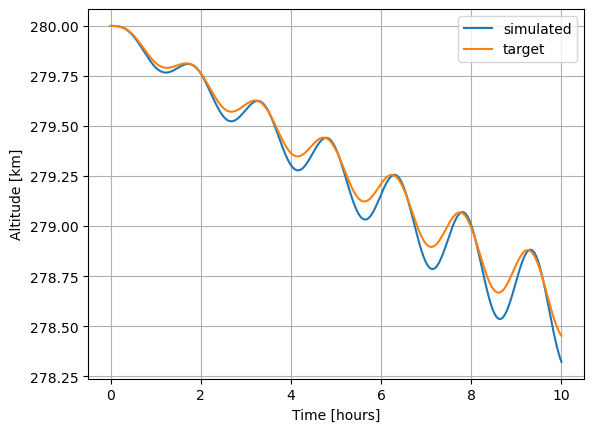

In [26]:
altitude_simulated = (np.sqrt(variational_equations_propagated[-1][:,0]**2+variational_equations_propagated[-1][:,1]**2+variational_equations_propagated[-1][:,2]**2)-r_earth)/1e3
altitude_target = (np.sqrt(sol.y.T[:,0]**2+sol.y.T[:,1]**2+sol.y.T[:,2]**2)-r_earth)/1e3
plt.plot(sol.t/60/60,altitude_simulated,label='simulated')
plt.plot(sol.t/60/60,altitude_target,label='target')
plt.grid()
plt.xlabel('Time [hours]')
plt.ylabel('Altitude [km]')
plt.legend()

all right, now that we have generated the reference trajectory, we can setup gradient descent iterations:

In [28]:
lr=1e-3
nn_parameters=flattened_nw.copy()
n_epochs=30
for epoch in range(n_epochs):
    #we first propagate the dynamics & variational equations:
    ta.state[:]=initial_state+ic_var
    ta.time=0.
    ta.pars[:]=nn_parameters
    variational_equations_propagated=ta.propagate_grid(times_target)
    #let's compute the term dloss_dx:
    dloss_dx=2*(variational_equations_propagated[-1][:,:6]-sol_target)
    #now the term dx_dw:
    dx_dw=variational_equations_propagated[-1][:,6+36:].reshape((len(sol_target),6,-1))
    #and we can therefore accumulate the graident dloss_dw for each point:
    dloss_dw=0.
    for i in range(dx_dw.shape[0]):
        dloss_dw+=dloss_dx[i,:]@dx_dw[i]#this will have shape: nn parameters
    dloss_dw/=dx_dw.shape[0]
    #we update the parameters:
    nn_parameters-=lr*dloss_dw
    if epoch%10==0:
        #we reduce the learning rate:
        lr*=0.9
    #we print the loss:
    loss=np.mean((variational_equations_propagated[-1][:,:6]-sol_target)**2)
    print("Epoch:",epoch,"Loss:",loss)

Epoch: 0 Loss: 189568.83521662073
Epoch: 1 Loss: 27814.874331603718
Epoch: 2 Loss: 7597.999185843271
Epoch: 3 Loss: 3060.3993768203154
Epoch: 4 Loss: 1909.2601884927135
Epoch: 5 Loss: 1575.8527034573865
Epoch: 6 Loss: 1464.3472340703747
Epoch: 7 Loss: 1421.905315423824
Epoch: 8 Loss: 1404.1785407792001
Epoch: 9 Loss: 1396.362249145115
Epoch: 10 Loss: 1392.852029392612
Epoch: 11 Loss: 1391.2883497312284
Epoch: 12 Loss: 1390.7174118957232
Epoch: 13 Loss: 1390.4711994624704
Epoch: 14 Loss: 1390.389648659349
Epoch: 15 Loss: 1390.4084654271533
Epoch: 16 Loss: 1390.4758224705558
Epoch: 17 Loss: 1390.569841402668
Epoch: 18 Loss: 1390.6860494463394
Epoch: 19 Loss: 1390.812524621502
Epoch: 20 Loss: 1390.9405670111414
Epoch: 21 Loss: 1391.0695087044119
Epoch: 22 Loss: 1391.1869115561683
Epoch: 23 Loss: 1391.3023847168395
Epoch: 24 Loss: 1391.418979616793
Epoch: 25 Loss: 1391.5347089262493
Epoch: 26 Loss: 1391.6528280461748
Epoch: 27 Loss: 1391.7710625064703
Epoch: 28 Loss: 1391.8972335880842
Epo

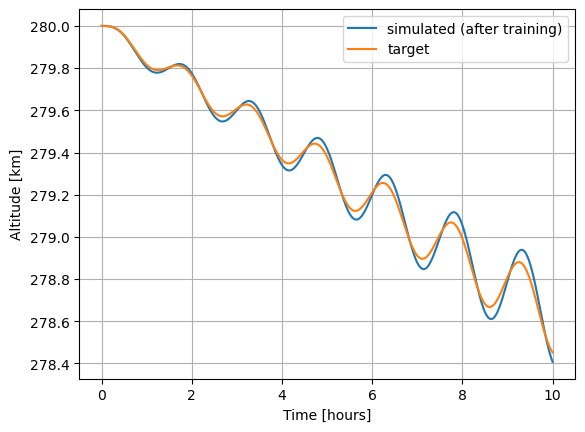

In [31]:
#let's plot the new trajectory:
ta.state[:]=initial_state+ic_var
ta.time=0.
ta.pars[:]=nn_parameters
variational_equations_propagated=ta.propagate_grid(sol.t)

altitude_simulated = (np.sqrt(variational_equations_propagated[-1][:,0]**2+variational_equations_propagated[-1][:,1]**2+variational_equations_propagated[-1][:,2]**2)-r_earth)/1e3
altitude_target = (np.sqrt(sol.y.T[:,0]**2+sol.y.T[:,1]**2+sol.y.T[:,2]**2)-r_earth)/1e3
plt.plot(sol.t/60/60,altitude_simulated,label='simulated (after training)')
plt.plot(sol.t/60/60,altitude_target,label='target')
plt.grid()
plt.xlabel('Time [hours]')
plt.ylabel('Altitude [km]')
plt.legend()